In [23]:
# Radiomics Feature Selection
# MWU Test + Spearman Correlation + LASSO Regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
import scipy.stats as stats
import os
from scipy.stats import spearmanr
import warnings
import time
from datetime import datetime
# import lightgbm as lgb
LIGHTGBM_AVAILABLE = True

# Plotting and font setup
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
warnings.filterwarnings('ignore')

In [24]:
# Figure A: Mean Square Error (MSE) vs Lambda
def plot_lasso_cv_curve(lasso_model, result_dir, timestamp):
    plt.figure(figsize=(6, 4))
    lambdas = lasso_model.alphas_
    mse_mean = lasso_model.mse_path_.mean(axis=1)
    mse_std = lasso_model.mse_path_.std(axis=1)
    optimal_lambda_idx = np.argmin(mse_mean)
    optimal_lambda = lambdas[optimal_lambda_idx]

    plt.errorbar(lambdas, mse_mean, yerr=mse_std, fmt='o', color='r', ecolor='lightblue',
                 elinewidth=1, capsize=2, capthick=1, markersize=2, alpha=1)
    plt.axvline(optimal_lambda, linestyle='--', color='k')
    plt.xscale('log')
    plt.xlabel('Lambda', fontsize=14)
    plt.ylabel('Mean Square Error', fontsize=14)
    plt.title('LASSO Cross-Validation Error', fontsize=14)
    plt.text(optimal_lambda * 1.1, min(mse_mean) * 1.25,
             f'Optimal λ = {optimal_lambda:.4f}', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{result_dir}/lasso_cv_error_{timestamp}.svg', format="svg", bbox_inches="tight")
    plt.savefig(f'{result_dir}/lasso_cv_error_{timestamp}.pdf', dpi=500)
    plt.close()
    return optimal_lambda

In [25]:
# Figure B: Feature Weight Coefficients vs. Lambda
def plot_lasso_path(lasso_model, feature_names, result_dir, X_no_nan, y, timestamp):
    alphas = lasso_model.alphas_
    coefs = []
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
        lasso.fit(X_no_nan, y)
        coefs.append(lasso.coef_)

    coefs = np.array(coefs)
    plt.figure(figsize=(6, 4))
    for i, feature_name in enumerate(feature_names):
        plt.plot(alphas, coefs[:, i], label=feature_name if i < 5 else "", linewidth=1)
    plt.axvline(lasso_model.alpha_, linestyle='--', color='k')
    plt.xscale('log')
    plt.xlabel('Lambda', fontsize=14)
    plt.ylabel('Feature weight coefficient', fontsize=14)
    plt.title('LASSO Regularization Path', fontsize=14)
    plt.text(lasso_model.alpha_ * 1.1, 0.12,
             f'Optimal λ = {lasso_model.alpha_:.4f}', fontsize=12)
    if len(feature_names) <= 5:
        plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{result_dir}/lasso_path_{timestamp}.svg', format="svg", bbox_inches="tight")
    plt.savefig(f'{result_dir}/lasso_path_{timestamp}.pdf', dpi=500)
    plt.close()

In [26]:
# Figure C: Selected Features Barplot
def plot_lasso_selected_features(lasso_model, feature_names, result_dir, timestamp):
    coef = lasso_model.coef_
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
    coef_df = coef_df[coef_df['Coefficient'] != 0].sort_values('Coefficient')

    plt.figure(figsize=(10, len(coef_df) * 0.4))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='lightblue', height=0.8)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.xlabel('Feature weight coefficient', fontsize=16)
    plt.ylabel('Feature name', fontsize=16)
    plt.title(f'Selected Features by LASSO (λ = {lasso_model.alpha_:.4f})', fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{result_dir}/lasso_selected_features_{timestamp}.svg', format="svg", bbox_inches="tight")
    plt.savefig(f'{result_dir}/lasso_selected_features_{timestamp}.pdf', dpi=500)
    plt.close()
    return coef_df

In [27]:
def load_data(file_path):
    print("Loading data...")
    df = pd.read_csv(file_path)
    df = df.drop(columns=['ct_id'])
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    feature_names = X.columns.tolist()
    print(f"Data loaded. Samples: {X.shape[0]}, Features: {X.shape[1]}")
    return X, y, feature_names

In [28]:
def process_features(X, model_type='lr'):
    if isinstance(X, pd.DataFrame):
        X_values = X.values
    else:
        X_values = X.copy()

    mean = np.mean(X_values, axis=0)
    std = np.std(X_values, axis=0)
    outlier_mask = (X_values > mean + 3 * std) | (X_values < mean - 3 * std)

    X_with_nan = X_values.copy()
    X_with_nan[outlier_mask] = np.nan
    X_filled = pd.DataFrame(X_with_nan).fillna(pd.DataFrame(X_with_nan).median()).values

    scaler = StandardScaler()
    X_processed = scaler.fit_transform(X_filled)
    print("Data preprocessing completed.")
    return X_processed, scaler

In [29]:
def univariate_feature_selection(X, y, feature_names, result_dir, p_threshold=0.05, test_method='mwu', alternative='two-sided'):
    print(f"Performing univariate feature selection using {test_method.upper()} test on all data...")
    X_no_nan = X.copy()
    p_values = []
    for i in range(X_no_nan.shape[1]):
        if test_method.lower() == 'ttest':
            _, p = stats.ttest_ind(X_no_nan[y == 0][:, i], X_no_nan[y == 1][:, i])
        elif test_method.lower() == 'mwu':
            _, p = stats.mannwhitneyu(X_no_nan[y == 0][:, i], X_no_nan[y == 1][:, i], alternative=alternative)
        else:
            raise ValueError("Unsupported test method. Choose from 'ttest' or 'mwu'.")
        p_values.append(p)

    selected_features = [i for i, p in enumerate(p_values) if p < p_threshold]
    selected_feature_names = [feature_names[i] for i in selected_features]

    print(f"Univariate feature selection complete. {len(selected_features)} features selected (p < {p_threshold}).")
    p_value_df = pd.DataFrame({'Feature': feature_names, 'P-value': p_values})
    p_value_df = p_value_df.sort_values('P-value')
    p_value_df.to_csv(f'{result_dir}/univariate_p_values.csv', index=False)
    return selected_features, selected_feature_names, p_value_df

In [30]:
def spearman_feature_selection(X, feature_names, corr_threshold=0.9, p_threshold=0.05):
    print(f"Performing Spearman correlation analysis (corr_threshold={corr_threshold}, p_threshold={p_threshold})...")
    n_features = X.shape[1]
    corr_matrix = np.zeros((n_features, n_features))
    p_matrix = np.zeros((n_features, n_features))

    for i in range(n_features):
        for j in range(i + 1, n_features):
            corr, p = spearmanr(X[:, i], X[:, j])
            corr_matrix[i, j] = corr_matrix[j, i] = corr
            p_matrix[i, j] = p_matrix[j, i] = p

    to_remove = set()
    for i in range(n_features):
        for j in range(i + 1, n_features):
            if abs(corr_matrix[i, j]) > corr_threshold and p_matrix[i, j] < p_threshold:
                to_remove.add(j)

    retained_features = [i for i in range(n_features) if i not in to_remove]
    retained_feature_names = [feature_names[i] for i in retained_features]
    print(f"Spearman correlation filtering complete. Kept {len(retained_features)} features, removed {len(to_remove)}.")
    return retained_features, retained_feature_names

In [31]:
def lasso_feature_selection(X, y, feature_names, result_dir, random_state, cv=10, max_iter=10000):
    print("Performing LASSO regression feature selection using all data...")
    X_no_nan = X.copy()
    alphas = np.logspace(-3, 0, 50)
    lasso_model = LassoCV(alphas=alphas, cv=cv, random_state=random_state, max_iter=max_iter)
    lasso_model.fit(X_no_nan, y)

    plot_lasso_cv_curve(lasso_model, result_dir, 'error')
    plot_lasso_path(lasso_model, feature_names, result_dir, X_no_nan, y, 'weight')
    coef_df = plot_lasso_selected_features(lasso_model, feature_names, result_dir, 'features')

    coef = lasso_model.coef_
    selected_features = np.where(coef != 0)[0]
    selected_feature_names = [feature_names[i] for i in selected_features]

    print(f"LASSO feature selection complete. {len(selected_features)} features selected.")
    print(f"Optimal alpha value: {lasso_model.alpha_:.6f}")
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
    coef_df = coef_df.loc[coef_df['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
    coef_df.to_csv(f'{result_dir}/lasso_coefficients_feature_important.csv', index=False)
    return selected_features, selected_feature_names, lasso_model, coef_df

In [32]:
def main():
    random_state = 0
    result_dir = "img_plot"
    os.makedirs(result_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Step 1: Load data
    file_path = 'table/pyradio_feature.csv'
    X, y, feature_names = load_data(file_path)

    # Step 2: Preprocess data
    model_type = 'lr'
    X_processed, scaler = process_features(X, model_type)

    # Step 3: Univariate feature selection (MWU)
    test_method = 'mwu'
    p_threshold = 0.05
    univariate_selected, univariate_names, p_value_df = univariate_feature_selection(
        X_processed, y, feature_names, result_dir, p_threshold, test_method
    )
    X_univariate = X_processed[:, univariate_selected]
    univariate_feature_names = [feature_names[i] for i in univariate_selected]

    # Step 4: Spearman correlation filtering
    if X_univariate.shape[1] > 0:
        spearman_selected, spearman_names = spearman_feature_selection(
            X_univariate, univariate_feature_names, corr_threshold=0.95, p_threshold=0.05
        )
        X_spearman = X_univariate[:, spearman_selected]
    else:
        print("No features passed univariate selection; using all original features.")
        X_spearman = X_processed
        spearman_names = feature_names

    # Step 5: LASSO feature selection
    if X_spearman.shape[1] > 0:
        lasso_selected, lasso_names, lasso_model, coef_df = lasso_feature_selection(
            X_spearman, y, spearman_names, result_dir, random_state
        )
        if len(lasso_selected) > 0:
            X_final = X_spearman[:, lasso_selected]
            final_feature_names = [spearman_names[i] for i in lasso_selected]
        else:
            print("LASSO did not select any features; using Spearman-filtered features.")
            X_final = X_spearman
            final_feature_names = spearman_names
    else:
        print("No features after Spearman filtering; using all original features.")
        X_final = X_processed
        final_feature_names = feature_names
        coef_df = pd.DataFrame()

    print(f"Final selected features ({len(final_feature_names)}): {final_feature_names}")

    # Step 6: Save results
    df = pd.read_csv(file_path)
    X_final_df = pd.DataFrame(X_final, columns=final_feature_names)
    X_final_df['label'] = df['label'].values
    X_final_df.insert(0, 'ct_id', df['ct_id'].values)
    X_final_df.to_csv(f'{result_dir}/processed_data.csv', index=False)

Loading data...
Data loaded. Samples: 105, Features: 1316
Data preprocessing completed.
Performing univariate feature selection using MWU test on all data...
Univariate feature selection complete. 321 features selected (p < 0.05).
Performing Spearman correlation analysis (corr_threshold=0.95, p_threshold=0.05)...
Spearman correlation filtering complete. Kept 163 features, removed 158.
Performing LASSO regression feature selection using all data...


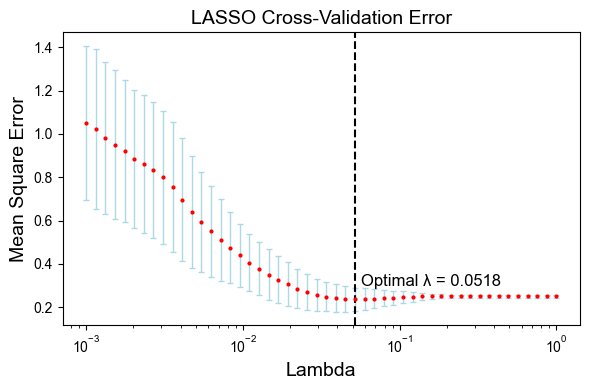

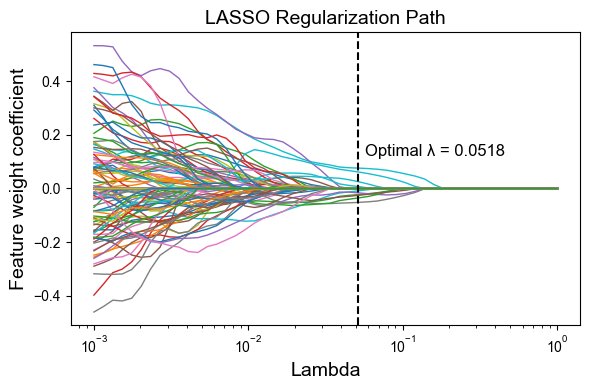

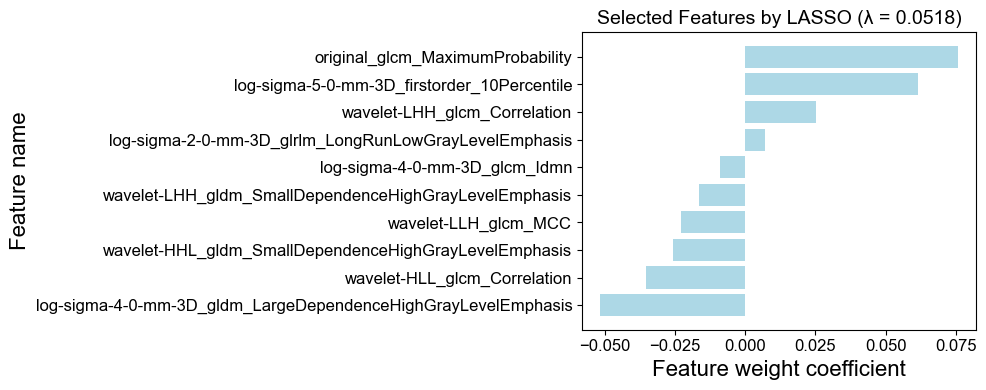

LASSO feature selection complete. 10 features selected.
Optimal alpha value: 0.051795
Final selected features (10): ['original_glcm_MaximumProbability', 'log-sigma-2-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis', 'log-sigma-4-0-mm-3D_glcm_Idmn', 'log-sigma-4-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis', 'log-sigma-5-0-mm-3D_firstorder_10Percentile', 'wavelet-LLH_glcm_MCC', 'wavelet-LHH_glcm_Correlation', 'wavelet-LHH_gldm_SmallDependenceHighGrayLevelEmphasis', 'wavelet-HLL_glcm_Correlation', 'wavelet-HHL_gldm_SmallDependenceHighGrayLevelEmphasis']


In [33]:
if __name__ == "__main__":
    main()